In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import itertools as it
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import random as rd

# for Jupyter Notebook
# %matplotlib notebook

# for vscode    
%matplotlib widget        

## Graph Helper

In [116]:
def create_network_graph(num_nodes:int = 50) -> nx.Graph:
    G_scale_free = nx.scale_free_graph(num_nodes)
    # G_network = G_scale_free.reverse()
    G_network = G_scale_free.to_undirected()
    G_network.remove_edges_from(nx.selfloop_edges(G_network))
    return G_network

In [117]:
def draw_graph(G: nx.Graph, G_type: str = "big"):
    if G_type == "big":
        pos = graphviz_layout(G, prog="neato")
        plt.figure(figsize=(40, 40))
        nx.draw(G, pos, arrows=False, node_color="grey", edge_color="black", with_labels=False, node_size=50)
    elif G_type == "small":
        pos = graphviz_layout(G, prog="neato")
        plt.figure(figsize=(10, 10))
        nx.draw(G, pos, arrows=False, node_color="grey", edge_color="black", with_labels=False, node_size=100)

    plt.show()
    plt.savefig("graph.svg")


def draw_colored_graph(G: nx.Graph):
    pos = graphviz_layout(G, prog="neato")
    plt.figure(figsize=(10, 10))

    cmap = plt.cm.jet  
    cmaplist = [cmap(i) for i in range(cmap.N)]
    rd.shuffle(cmaplist)

    color = [cmaplist[data["opinion"]%cmap.N] for _, data in G.nodes(data=True)]
    nx.draw(G, pos, arrows=False, node_color=color, edge_color="black", with_labels=False, node_size=100)

    plt.show()

## Opinion Diversity Simulation

#### Diversity Index (TODO)

In [118]:
def calc_diversity_index(G: nx.Graph):
    avg_M_G = 0 
    Delta_G = avg_M_G / G.number_of_nodes() 
    return Delta_G

#### Simulation Logic

In [119]:
def calc_opinion_diversity(G: nx.Graph):
    opinion_count = {}
    for node in G.nodes():
        opinion = str(G.nodes[node]['opinion'])
        if opinion not in opinion_count:
            opinion_count[opinion] = 0
        opinion_count[opinion] += 1

    total_nodes = G.number_of_nodes()
    diversity_index = sum((count / total_nodes) ** 2 for count in opinion_count.values())
    return 1 - diversity_index

def kumulative_opinion_diversity(G: nx.Graph, it_counter:int, index_sum: list):
    return index_sum / it_counter


def init_opinions(G: nx.Graph, num_opinions: int = 2):
    # initialize the graph with random opinions
    for node in G.nodes():
        G.nodes[node]['opinion'] = np.random.randint(0, num_opinions)
    G.graph['diversity_index_sum'] = 0
    return G

def iterate_dispersion(G: nx.Graph, opinion_counter, r):
    for node in G.nodes():
        do_inovate = np.random.rand() < r
        if do_inovate:
            G.nodes[node]['next_opinion'] = next(opinion_counter)

        else:
            neighbors = list(G.neighbors(node))
            neighbors.append(node)  # include self in neighbors
            neighbor_opinions = [G.nodes[neigh]['opinion'] for neigh in neighbors]
            G.nodes[node]['next_opinion'] = np.random.choice(neighbor_opinions)
    for node in G.nodes():
        G.nodes[node]['opinion'] = G.nodes[node]['next_opinion']
    return G

def simulate_opinion_dispersion(G: nx.Graph, iterations: int = 100, num_opinions: int = 2, r: float = 0.05):
    G = init_opinions(G, num_opinions)
    opinion_counter = it.count(num_opinions)
    for i in range(iterations):
        G = iterate_dispersion(G, opinion_counter, r)
        diversity_index = calc_opinion_diversity(G)
        G.graph['diversity_index_sum'] += diversity_index
        kum_diversity_index = kumulative_opinion_diversity(G, i + 1, G.graph['diversity_index_sum'])
    return G, kum_diversity_index

#### Simulation Animation


In [120]:
def animate_simulation(G: nx.Graph, iterations: int = 100, fps: int = 1, num_opinions: int = 2, r: float = 0.05):
    pos = graphviz_layout(G, prog="neato")
    fig, ax = plt.subplots(figsize=(10, 10))

    cmap = plt.cm.jet  # define the colormap
    cmaplist = [cmap(i) for i in range(cmap.N)]
    rd.shuffle(cmaplist)
    get_colors = lambda G: [cmaplist[data["opinion"]%cmap.N] for _, data in G.nodes(data=True)]

    opinion_counter = it.count(num_opinions)
    graph_plt = nx.draw(G, pos, ax, arrows=False, node_color="grey", edge_color="black", with_labels=False, node_size=100)
    text_plt = ax.text(0, 0, "")

    def init(G):
        G = init_opinions(G, num_opinions)
        colors = get_colors(G) 
        graph_plt.set_color(colors)
        return graph_plt

    def update(i, G, opinion_counter):
        if i == iterations:
            ani.event_source.stop()
            return graph_plt
 
        G = iterate_dispersion(G, opinion_counter, r)
        colors = get_colors(G) 
        graph_plt.set_color(colors)

        diversity_index = calc_opinion_diversity(G)
        G.graph['diversity_index_sum'] += diversity_index
        kum_diversity_index = kumulative_opinion_diversity(G, i + 1, G.graph['diversity_index_sum'])
        text_plt.set_text(f"Iteration: {i+1}\n$\Delta (G): {diversity_index:.2f}$\n $\Delta_\infty (G): {kum_diversity_index:.2f}$")
        return graph_plt

    ani = animation.FuncAnimation(
        fig, 
        update,
        fargs=(G, opinion_counter,), 
        init_func=lambda: init(G), interval=1000*(1/fps), blit=True, save_count=50)
    
    plt.show()
    return ani


def save_animation(ani, filename: str = "opinion_dispersion.gif"):
    writergif = animation.PillowWriter(fps=10)
    ani.save(filename, writer=writergif)
    print(f"Animation saved as {filename}")

#### Small Test Graphs

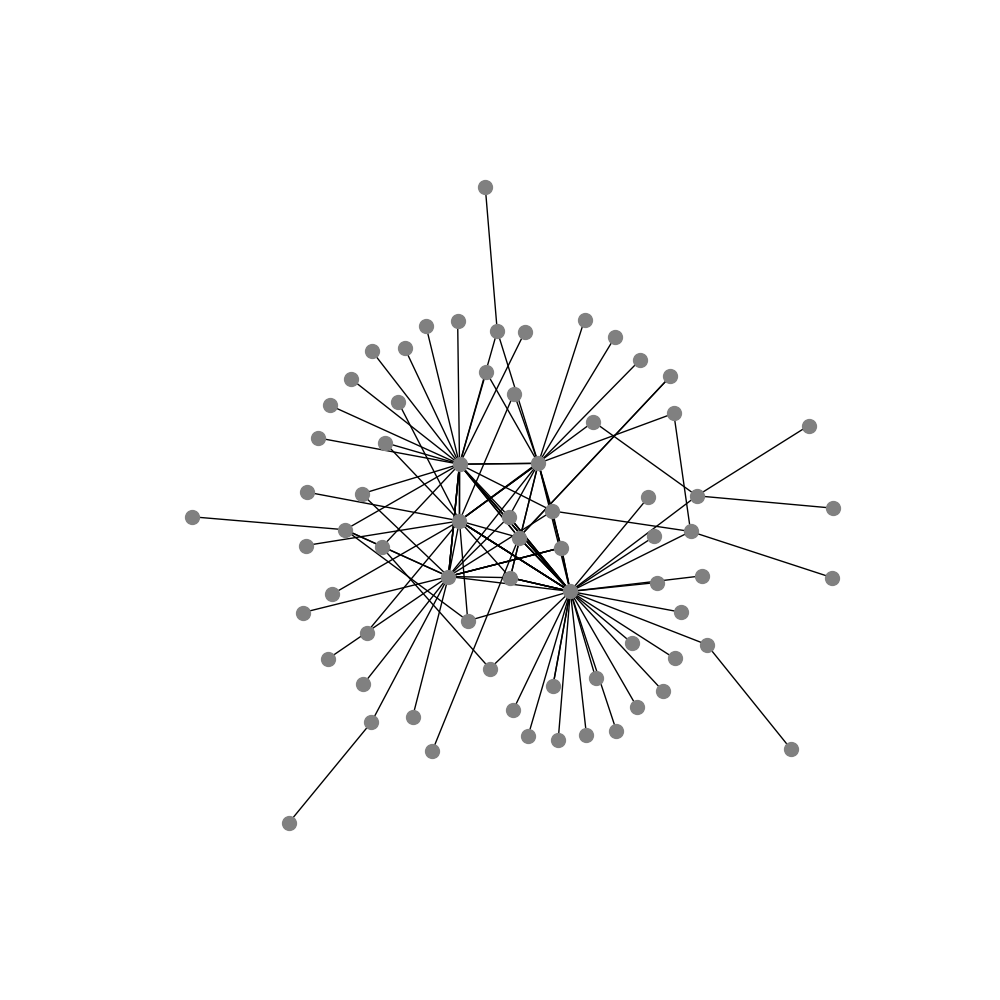

Animation saved as opinion_dispersion.gif


In [121]:
# G = create_network_graph(num_nodes=10)
# G = init_opinions(G, num_opinions=2)
# opinion_counter = it.count(2)
# G = iterate_dispersion(G, opinion_counter, 0.2)

G = create_network_graph(num_nodes=70)
ani = animate_simulation(G, iterations=300, fps=10, num_opinions=2, r=0.01)
save_animation(ani, filename="opinion_dispersion.gif")

## Real World Graphs

### Facebook Data Set (4039 Nodes and 88234 Edges)

In [122]:
data_path = r"C:\Users\Alex\OneDrive\IT\ETH\Semester 6\TSD\DATA\fb_stanford\combined.txt"          # Whole Dataset (!)
# data_path = r"C:\Users\Alex\OneDrive\IT\ETH\Semester 6\TSD\DATA\fb_stanford\ego_networks\107.edges"  # Ego Network (107)

G = nx.read_edgelist(data_path, nodetype=int)

# draw_graph(G)
# animate_simulation(G, iterations=30, fps=1, num_opinions=2, r=0.001)
# simulate_opinion_dispersion(G, iterations=30, num_opinions=2, r=0.01)

### Highschool Friendship Data Set (70 Nodes and 274 Edges)

70 274


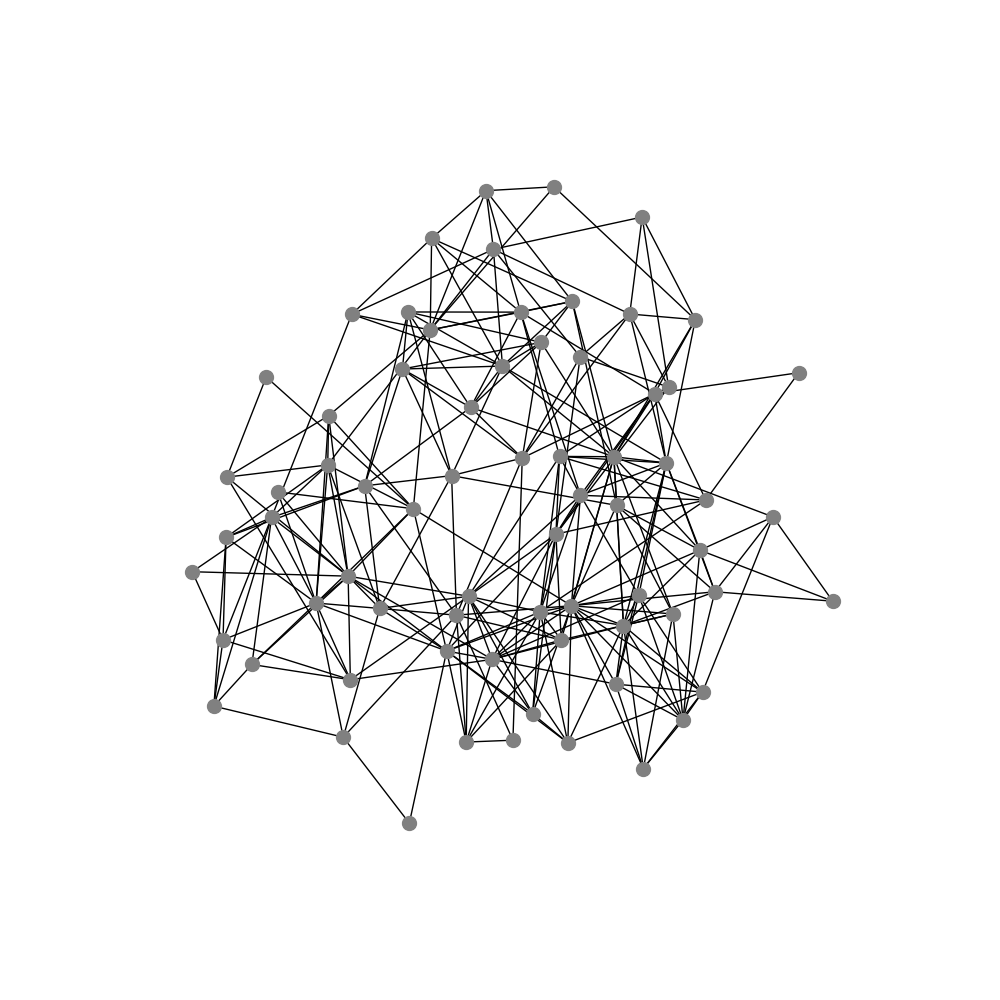

In [124]:
data_path = r"C:\Users\Alex\OneDrive\IT\ETH\Semester 6\TSD\DATA\moreno_highschool\out.moreno_highschool_highschool"          

G = nx.read_edgelist(data_path, nodetype=int, data=(("weight", float),))
G = G.to_undirected()
print(G.number_of_nodes(), G.number_of_edges())
animate_simulation(G, iterations=300, fps=10, num_opinions=2, r=0.01)